<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [222]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [223]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error

## Задание 1 (1 балл). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекомендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



Возьмем один из "популярных" временных рядов по приведенной выше ссылке

In [224]:
# скачаем данные
!wget https://github.com/rishabh89007/Time_Series_Datasets/blob/main/Brent%20Spot%20Price.csv
!wget https://github.com/rishabh89007/Time_Series_Datasets/blob/main/Nuclear%20Capacity.csv
# по ссылкам скачать не удалось, пандас не считывает скаченные wget'ом файлы

--2022-04-26 17:42:56--  https://github.com/rishabh89007/Time_Series_Datasets/blob/main/Brent%20Spot%20Price.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Brent Spot Price.csv.2’

Brent Spot Price.cs     [ <=>                ] 212.23K  --.-KB/s    in 0.03s   

2022-04-26 17:42:56 (7.01 MB/s) - ‘Brent Spot Price.csv.2’ saved [217325]

--2022-04-26 17:42:56--  https://github.com/rishabh89007/Time_Series_Datasets/blob/main/Nuclear%20Capacity.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Nuclear Capacity.csv.2’

Nuclear Capacity.cs     [ <=>                ]   1.22M  --.-KB/s    in 0.05s   

2022-04-26 17:42:57 (26.8 MB/s) - ‘Nuclear Capacity.csv.2’ saved [1

In [225]:
# считаем файлы
ts1 = pd.read_csv('Brent Spot Price.csv') # месячная частота
ts2 = pd.read_csv('Nuclear Capacity.csv') # дневная частота

Preprocessing of Brent Spot Price.csv



In [226]:
# посмотрим на данные Brent Spot Price.csv
ts1.head()

,Unnamed: 0,"Brent crude oil spot price, Monthly (dollars per barrel)"
0,1990 01,21.251
1,1990 02,19.813
2,1990 03,18.387
3,1990 04,16.612
4,1990 05,16.352


In [227]:
# перепишем дату в новый столбец и удалим старый
ts1.rename(columns = {'Brent crude oil spot price, Monthly (dollars per barrel)' : 'value'}, inplace = True) 
ts1['date'] = ts1['Unnamed: 0'].apply(lambda x: pd.to_datetime(x[:-1], format='%Y %m'))
ts1.drop(columns=['Unnamed: 0'], inplace=True)

In [228]:
ts1.head()

,value,date
0,21.251,1990-01-01
1,19.813,1990-02-01
2,18.387,1990-03-01
3,16.612,1990-04-01
4,16.352,1990-05-01


Preprocessing of Nuclear Capacity.csv

In [229]:
# посмотрим на данные Nuclear Capacity.csv
ts2.head()

,Unnamed: 0,"U.S. nuclear capacity, daily (Megawatts)"
0,2007 0101 01,101764.9
1,2007 0102 02,101764.9
2,2007 0103 03,101764.9
3,2007 0104 04,101764.9
4,2007 0105 05,101764.9


In [230]:
# перепишем дату в новый столбец и удалим старый
def date_preprocessing(x):
  """Функция записи даты в нужном виде"""
  buf = x.split()
  year = buf[0]
  buf_2 = buf[1]
  day = buf_2[2:]
  month = buf_2[:2]
  data = year + '-' + month + '-' + day
  return data

ts2.rename(columns = {'U.S. nuclear capacity, daily (Megawatts)' : 'value'}, inplace = True)
ts2['date'] = ts2['Unnamed: 0'].apply(lambda x: date_preprocessing(x))
ts2.drop(columns=['Unnamed: 0'], inplace=True) 

In [231]:
ts2.head()

,value,date
0,101764.9,2007-01-01
1,101764.9,2007-01-02
2,101764.9,2007-01-03
3,101764.9,2007-01-04
4,101764.9,2007-01-05


In [232]:
# сделаем разбиение на train/test
percent = 0.8
ts1_train = ts1.iloc[:int(percent*len(ts1))]
ts1_test = ts1.iloc[int(percent*len(ts1)) + 1:]

ts2_train = ts2.iloc[:int(percent*len(ts2))]
ts2_test = ts2.iloc[int(percent*len(ts2)) + 1:]

X_train_1 = ts1_train['date']
y_train_1 = ts1_train['value']
X_test_1 = ts1_test['date']
y_test_1 = ts1_test['value']

X_train_2 = ts2_train['date']
y_train_2 = ts2_train['value']
X_test_2 = ts2_test['date']
y_test_2 = ts2_test['value']

## Задание 2. Анализ временных рядов (1 балл).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики [автокорреляционных функций](https://www.machinelearningmastery.ru/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788/) для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

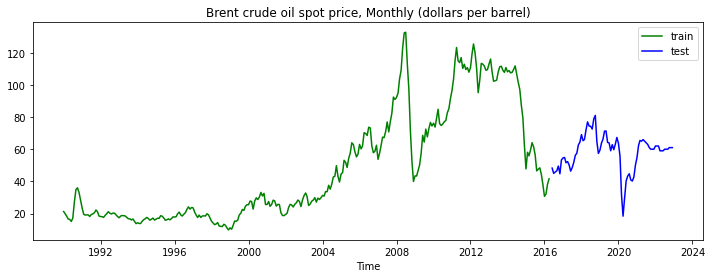

In [233]:
# Временные ряды для Brent Spot Price.csv
plt.figure(figsize=(12, 4))
plt.plot(X_train_1, y_train_1, c='green', label='train')
plt.plot(X_test_1, y_test_1, c='blue', label='test')
plt.legend()
plt.title("Brent crude oil spot price, Monthly (dollars per barrel)")
plt.xlabel('Time')
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


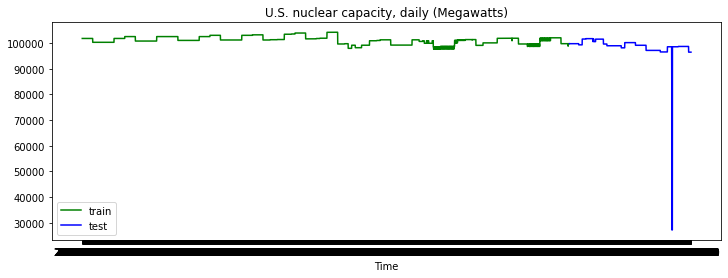

In [234]:
# Временные ряды для Nuclear Capacity.csv
plt.figure(figsize=(12, 4))
plt.plot(X_train_2, y_train_2, c='green', label='train')
plt.plot(X_test_2, y_test_2, c='blue', label='test')
plt.legend()
plt.title("U.S. nuclear capacity, daily (Megawatts)")
plt.xlabel('Time')
plt.show()

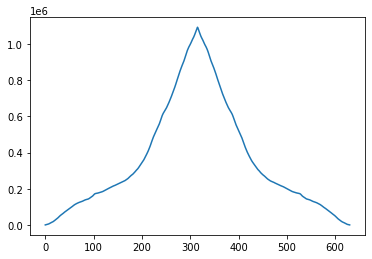

In [235]:
# посчитайте и нарисуйте график автокорреляционной функции
# hint, используйте для этого np.correlate(..., mode='full')
plt.plot(np.correlate(y_train_1, y_train_1, mode='full'))

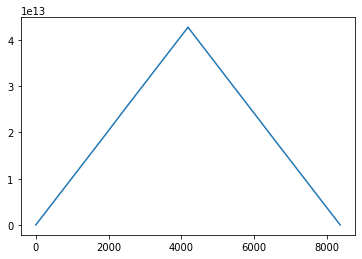

In [236]:
plt.plot(np.correlate(y_train_2, y_train_2, mode='full'))

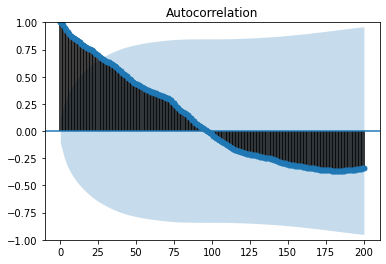

In [237]:
plot_acf(y_train_1, lags=200)
plt.show()

На данном графике сложно выделить сезонность

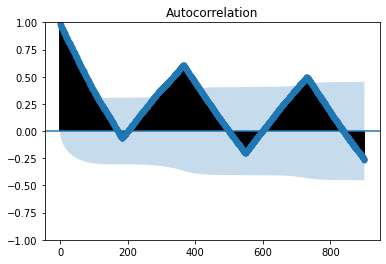

In [238]:
plot_acf(y_train_2, lags=900)
plt.show()

На данном графике видна сезонная составляющая по годам (годовая сезонность), так как длина основания примерно равна году (примерно 365 дней).

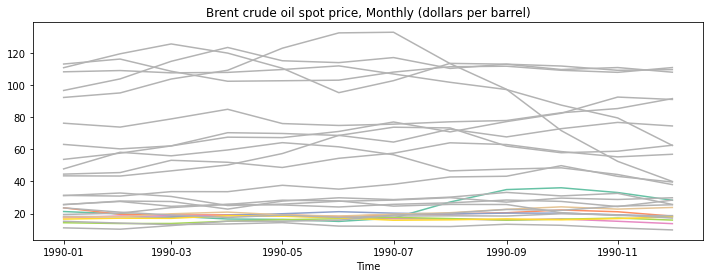

In [239]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными
# Временной ряд для Brent Spot Price (сезонность - 12)
period = 12
n = int(X_train_1.shape[0] / period)
colors = [plt.cm.Set2(i) for i in range(n)] # устанавливаем цвета

plt.figure(figsize=(12, 4))
for i in range(n):
    plt.plot(X_train_1[:period], y_train_1[period * i: period * (i+1)], c=colors[i])

plt.title("Brent crude oil spot price, Monthly (dollars per barrel)")
plt.xlabel('Time')
plt.show()
# каждая линия это свой год

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

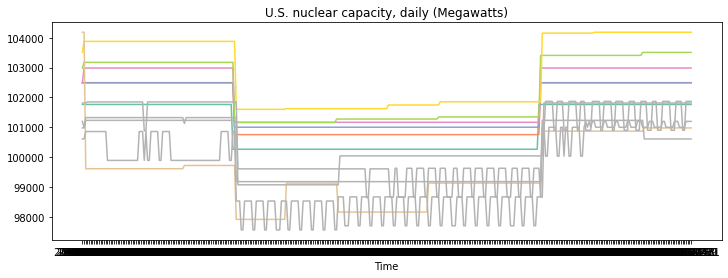

In [240]:
# Временной ряд для Nuclear Capacity(сезонность - 365)
period = 365
n = int(X_train_2.shape[0] / period)
colors = [plt.cm.Set2(i) for i in range(n)] # устанавливаем цвета

plt.figure(figsize=(12, 4))
for i in range(n):
    plt.plot(X_train_2[:period], y_train_2[period * i: period * (i+1)], c=colors[i])

plt.title("U.S. nuclear capacity, daily (Megawatts)")
plt.xlabel('Time')
plt.show()

## Задание 3. Предсказание месячного временного ряда (4 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной ряд несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.

### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [241]:
!pip install sktime

In [242]:
from sktime.forecasting.naive import NaiveForecaster

# ваш код обучения моделей здесь
model_1 = NaiveForecaster(strategy='last')
model_1.fit(y_train_1)
y_pred_1 = model_1.predict(X_test_1.index)


In [243]:
# посчитайте метрики на test
MAE_ = mean_absolute_error(y_pred_1, y_test_1)
print("MAE Naive Forecaster:", MAE_)

MAE Naive Forecaster: 17.6502911392405


Отрисуем метрики

In [244]:
!pip uninstall matplotlib # пришлось переустановить другую версию, иначе график не отображался
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.1
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbi

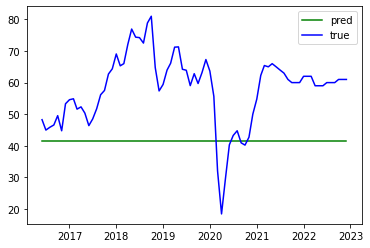

In [245]:
plt.plot(X_test_1, y_pred_1, c="g", label='pred')
plt.plot(X_test_1, y_test_1, c="b", label='true')

plt.legend()
plt.show()

Получили константный прогноз(

Тестируем Seasonal strategy

In [246]:
# ваш код обучения моделей здесь
model_2 = NaiveForecaster(strategy="mean", window_length=21, sp=13)
model_2.fit(y_train_1)
y_pred_2 = model_2.predict(X_test_1.index)

In [247]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_2, y_test_1)
print("MAE NaiveForecaster mean:", MAE)


MAE NaiveForecaster mean: 12.084278481012655


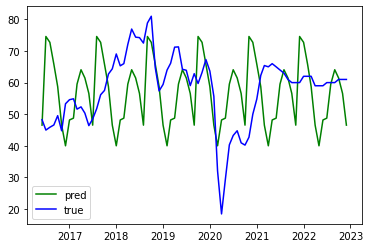

In [248]:
plt.plot(X_test_1, y_pred_2, c="g", label='pred')
plt.plot(X_test_1, y_test_1, c="b", label='true')
plt.legend()
plt.show()

Получили уже не константный прогноз, но качество прогнозирования все еще не очень

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

In [249]:
from statsmodels.compat.pandas import *
from pandas.util._decorators import Appender
from sktime.forecasting.arima import ARIMA, AutoARIMA
# ваш код обучения моделей здесь
my_arima = ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
my_arima.fit(y_train_1)
y_pred_arima = my_arima.predict(X_test_1.index)

In [250]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_arima, y_test_1)
print("MAE Arima mean:", MAE)

MAE Arima mean: 9.507404851885362


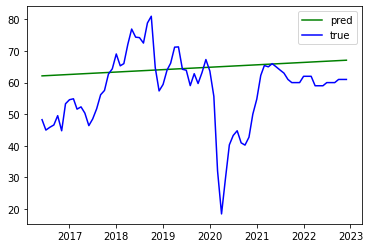

In [251]:
plt.plot(X_test_1, y_pred_arima, c="g", label='pred')
plt.plot(X_test_1, y_test_1, c="b", label='true')
plt.legend()
plt.show()

In [252]:
my_arima = AutoARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
my_arima.fit(y_train_1)
y_pred_auto_arima = my_arima.predict(X_test_1.index)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [253]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_auto_arima, y_test_1)
print("MAE Auto Arima:", MAE)

MAE Auto Arima: 15.865891185322445


### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [254]:
# from orbit.models.lgt import LGTFull
# from orbit.models.dlt import DLTFull

from orbit.models.lgt import LGT
from orbit.models.dlt import DLT
# ваш код обучения моделей здесь
my_lgt = LGT(response_col='value', date_col='date', seasonality=12, seed=73289)
my_lgt.fit(ts1_train)
y_pred_LGT = my_lgt.predict(ts1_test)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [255]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_LGT['prediction'], y_test_1)
print("MAE LGT:", MAE)

MAE LGT: 13.256409783590554


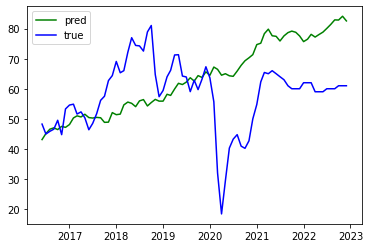

In [256]:
plt.plot(X_test_1, y_pred_LGT['prediction'], c="g", label='pred')
plt.plot(X_test_1, y_test_1, c="b", label='true')
plt.legend()
plt.show()

In [257]:
my_dlt = DLT(response_col='value', date_col='date', seasonality=12, seed=73289)
my_dlt.fit(ts1_train)
y_pred_DLT = my_dlt.predict(ts1_test)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [258]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_DLT['prediction'], y_test_1)
print("MAE DLT:", MAE)

MAE DLT: 10.894071419230874


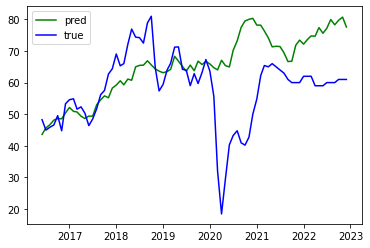

In [259]:
plt.plot(X_test_1, y_pred_DLT['prediction'], c="g", label='pred')
plt.plot(X_test_1, y_test_1, c="b", label='true')
plt.legend()
plt.show()

### ETS (1 балл).

Обучите из библиотеки `sktime` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [260]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь
model_ets_aaa = ExponentialSmoothing(sp=12)
model_ets_aaa.fit(y_train_1)
y_pred_ets_aaa = model_ets_aaa.predict(X_test_1.index)

In [261]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_ets_aaa, y_test_1)
print("MAE ETS AAA:", MAE)

MAE ETS AAA: 17.650291181867445


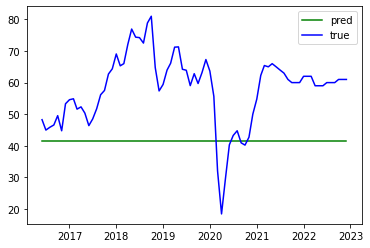

In [262]:
plt.plot(X_test_1, y_pred_ets_aaa, c="g", label='pred')
plt.plot(X_test_1, y_test_1, c="b", label='true')
plt.legend()
plt.show()

In [263]:
# ваш код обучения моделей здесь
model_ets_aic = AutoETS(auto=True, sp=12)
model_ets_aic.fit(y_train_1)
y_pred_ets_aic = model_ets_aic.predict(X_test_1.index)

In [264]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_ets_aaa, y_test_1)
print("MAE ETS AIC:", MAE)

MAE ETS AIC: 17.650291181867445


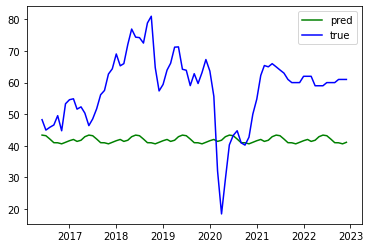

In [265]:
plt.plot(X_test_1, y_pred_ets_aic, c="g", label='pred')
plt.plot(X_test_1, y_test_1, c="b", label='true')
plt.legend()
plt.show()

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

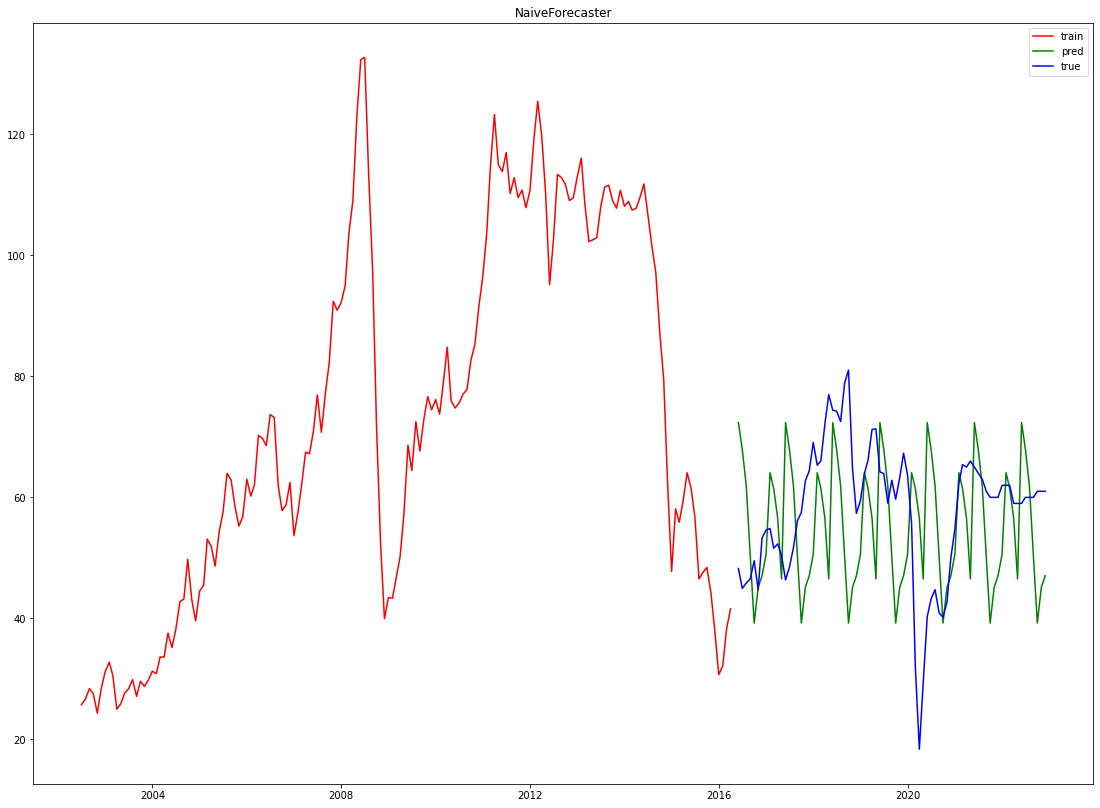

In [266]:
# нарисуйте пресказания
my_naiv_forecaster = NaiveForecaster(strategy="mean", window_length=20, sp=12)
my_naiv_forecaster.fit(y_train_1)
y_pred_naive = my_naiv_forecaster.predict(X_test_1.index)

plt.figure(figsize=(19, 14))
plt.plot(X_train_1[150:], y_train_1[150:], c="r", label='train')
plt.plot(X_test_1, y_pred_naive, c="g", label='pred')
plt.plot(X_test_1, y_test_1, "b", label='true')
plt.legend()
plt.title("NaiveForecaster")
plt.show()

## Задание 4. Предсказание дневного временного ряда (3 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [267]:
from sktime.forecasting.naive import NaiveForecaster

# ваш код обучения моделей здесь
model_1_naiv = NaiveForecaster(strategy='last')
model_1_naiv.fit(y_train_2)
y_pred_naive = model_1_naiv.predict(X_test_2.index)

In [268]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_naive, y_test_2)
print("MAE Naive Forecaster:", MAE)

MAE Naive Forecaster: 1667.5659003831447


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


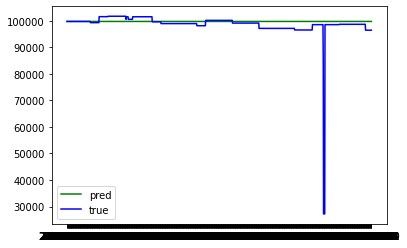

In [269]:
plt.plot(X_test_2, y_pred_naive, c="g", label='pred')
plt.plot(X_test_2, y_test_2, c="b", label='true')
plt.legend()
plt.show()

In [270]:
# ваш код обучения моделей здесь
model_1_naiv_2 = NaiveForecaster(strategy="mean", window_length=700, sp=365)
model_1_naiv_2.fit(y_train_2)
y_pred_naive_2 = model_1_naiv_2.predict(X_test_2.index)

In [271]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_naive_2, y_test_2)
print("MAE Naive Forecaster mean:", MAE)

MAE Naive Forecaster mean: 2570.037116858241


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


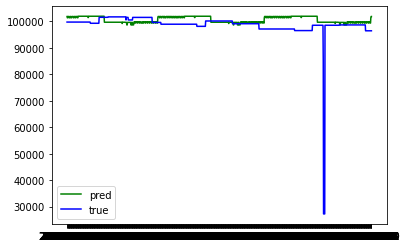

In [272]:
plt.plot(X_test_2, y_pred_naive_2, c="g", label='pred')
plt.plot(X_test_2, y_test_2, c="b", label='true')
plt.legend()
plt.show()

### KTR из orbit (1 балл).



In [273]:
from orbit.models.ktrlite import KTRLite

# ваш код обучения моделей здесь
model_ktr = KTRLite(response_col='value', date_col='date', seasonality=365)
model_ktr.fit(ts2_train)
y_pred_ktr = model_ktr.predict(ts2_test)

In [274]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_ktr['prediction'], y_test_2)
print("MAE Naive Forecaster mean:", MAE)

MAE Naive Forecaster mean: 2445.2475368403384


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


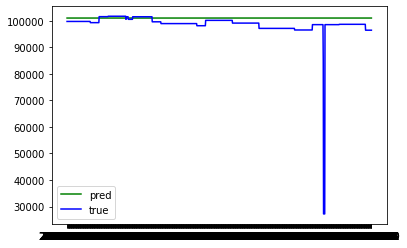

In [275]:
plt.plot(X_test_2, y_pred_ktr['prediction'], c="g", label='pred')
plt.plot(X_test_2, y_test_2, c="b", label='true')
plt.legend()
plt.show()

### Phophet (1 балл).



In [276]:
from prophet import Prophet

# ваш код обучения моделей здесь
ts2_train_prophet, ts2_test_prophet = ts2.rename(columns = {'date' : 'ds', 'value' : 'y'}), ts2.rename(columns = {'date' : 'ds', 'value' : 'y'}) 

model_prophet = Prophet()
model_prophet.fit(ts2_train_prophet)
future_data = model_prophet.make_future_dataframe(periods=365)
y_pred_prophet = model_prophet.predict(future_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [277]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_prophet[-1044:]['yhat'], y_test_2)
print("MAE Naive Forecaster mean:", MAE)

MAE Naive Forecaster mean: 2506.1211993993124


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


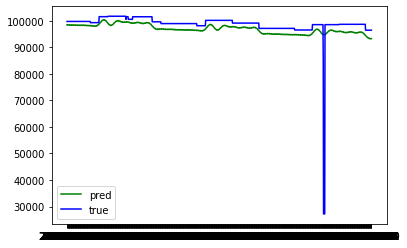

In [278]:
plt.plot(X_test_2, y_pred_prophet[-1044:]['yhat'], c="g", label='pred')
plt.plot(X_test_2, y_test_2, c="b", label='true')
plt.legend()
plt.show()

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

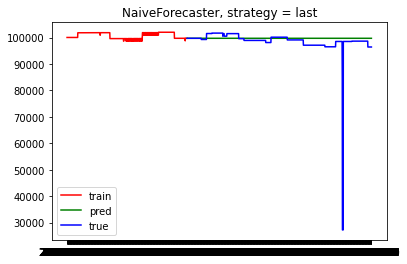

In [279]:
# нарисуйте пресказания
model_naive_last = NaiveForecaster(strategy='last')
model_naive_last.fit(y_train_2)
y_pred_naive_last = model_naive_last.predict(X_test_2.index)

plt.plot(X_train_2[3500:], y_train_2[3500:], c="r", label='train')
plt.plot(X_test_2, y_pred_naive_last, c="g", label='pred')
plt.plot(X_test_2, y_test_2, "b", label='true')
plt.legend()
plt.title("NaiveForecaster, strategy = last")
plt.show()

## Задание 5. Предсказание временного ряда моделями машинного обучения (1 балл).

Возьмите один из ваших рядов, сформируйте по нему матрицу объект-признак и целевой вектор.

Разбейте данные на train/test в той же пропорции, что разбивали в заданиях выше.

Обучите различные классические модели машинного обучения и оцените их качество (MAE). 

Какая из моделей справилась с задачей предсказания лучше всего?

In [280]:
# обучите классические модели ML
X = pd.DataFrame()
X['year'] = ts1['date'].apply(lambda x: str(x)[:4])
X['month'] = ts1['date'].apply(lambda x: str(x)[5:7])
# X['day'] = ts2['date'].apply(lambda x: str(x)[8:10])
y = ts1['value']

In [281]:
X_train = X.iloc[:int(percent*len(X))]
y_train = y.iloc[:int(percent*len(X))]
X_test = X.iloc[int(percent*len(X)):]
y_test = y.iloc[int(percent*len(X)):]

In [282]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(X_train, y_train)
y_pred_lin_reg = pd.DataFrame(lin_reg.predict(X_test), columns = ['Pred_value'])

In [283]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_lin_reg, y_test)
print("MAE Linear Regression:", MAE)

MAE Linear Regression: 49.89580136845291


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


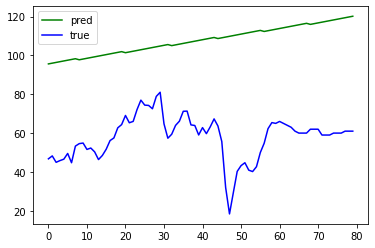

In [284]:
print(type(y_pred_lin_reg))
print(type(X_train))
plt.plot(np.arange(len(y_test)), y_pred_lin_reg, c="g", label='pred')
plt.plot(np.arange(len(y_test)), y_test, c="b", label='true')
plt.legend()
plt.show()

In [285]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rand_forest = RandomForestRegressor()
rand_forest.fit(X_train, y_train)
y_pred_rand_forest = rand_forest.predict(X_test)

In [286]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_rand_forest, y_test)
print("MAE Random Forest Regressor:", MAE)

MAE Random Forest Regressor: 20.028918124999983


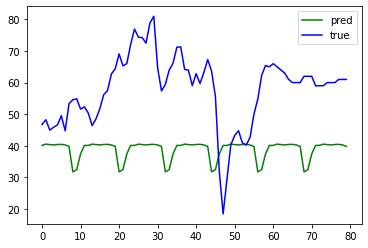

In [287]:
plt.plot(np.arange(len(y_test)), y_pred_rand_forest, c="g", label='pred')
plt.plot(np.arange(len(y_test)), y_test, c="b", label='true')
plt.legend()
plt.show()

In [288]:
grad_boost = GradientBoostingRegressor()
grad_boost.fit(X_train, y_train)
y_pred_grad_boost = grad_boost.predict(X_test)

In [289]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_grad_boost, y_test)
print("MAE Gradient Boosting:", MAE)

MAE Gradient Boosting: 23.54435810093678


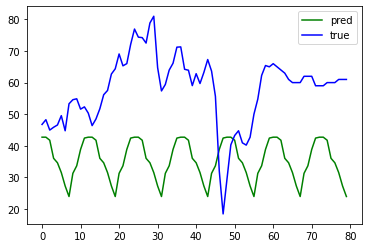

In [290]:
plt.plot(np.arange(len(y_test)), y_pred_grad_boost, c="g", label='pred')
plt.plot(np.arange(len(y_test)), y_test, c="b", label='true')
plt.legend()
plt.show()

In [291]:
from sklearn.neighbors import KNeighborsRegressor

k_neighbours = KNeighborsRegressor(n_neighbors=12)
k_neighbours.fit(X_train, y_train)
y_pred_neighbours = k_neighbours.predict(X_test)

In [292]:
# посчитайте метрики на test
MAE = mean_absolute_error(y_pred_neighbours, y_test)
print("MAE K_neighbours:", MAE)

MAE K_neighbours: 11.852946874999999


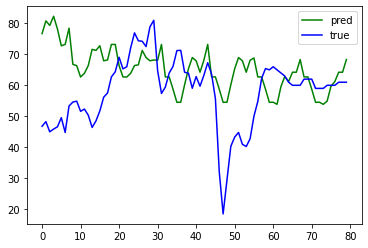

In [293]:
plt.plot(np.arange(len(y_test)), y_pred_neighbours, c="g", label='pred')
plt.plot(np.arange(len(y_test)), y_test, c="b", label='true')
plt.legend()
plt.show()

K_neighbours_regressor справился с задачей лучше всего, MAE получилось самым маленьким для данного метода, что визуально также подтверждается графиком


## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытайте свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной моделью на тестовой выборке с помощью MAE. 

Комментарий: итоговый балл за домашнее задание ставится по формуле минимум(10, ваш суммарный балл за задания).

In [294]:
# ваш код модели на STAN и её обучения здесь

In [295]:
# посчитайте метрики на test

In [296]:
# нарисуйте предсказания